# Teacher Student Learning for Reinforcement Learning Agents

In this we have followed the ideas from the following two papers: 

- Teaching on a Budget: Agents Advising Agents in Reinforcement Learning 
  ( https://www.eecs.wsu.edu/~taylorm/Publications/AAMAS13-Torrey.pdf )
 
- Learning to Teach Reinforcement Learning Agents
  ( https://arxiv.org/abs/1707.09079 )

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

##  Basic TDAgent 

Here the TDAgent has capabilities to act as a student as well as an independent agent. 
The TD Algorithms which this can use include: 
- Q-Learning
- SARSA
- Expected-SARSA

## Environment Information 
   The environment selected is "Taxi-V3". 
   Given below is some information regarding its implementation in gym. [https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py]

    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Observations: 
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
        
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east 
    - 3: move west 
    - 4: pickup passenger
    - 5: dropoff passenger
  
    Rewards: 
    There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
Note that the illegal pickup/dropoff has been termed as a penalty in our implementation and plots. And we have also used the count of number of penalties as a metric for evaluation.
For more details on the environment please refer to this link: 
https://gym.openai.com/envs/Taxi-v3/

In [2]:
class TDAgent():
    def __init__(self,algorithm, teacher=None, gamma=0.8, alpha=0.1):
        self.gamma = gamma
        self.alpha = alpha
        self.algorithm = algorithm
        self.teacher = teacher
        self.env = gym.make("Taxi-v3") # environment creation
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n]) # Q value for state-action
        self.actions = np.arange(self.env.action_space.n) # action space
        self.policy = np.full([self.env.observation_space.n, self.env.action_space.n],1.0/len(self.actions))
        self.state = self.env.reset()
        self.numSteps = 0
        self.eps = 0.0
    
    def reset(self):
        self.state = self.env.reset()
        return self.state
    
    def recommend( self, action, epsilon=0.1):
        if action >= len(self.actions):
            self.update_policy(self.state, epsilon)
            action = self.getAction(self.state)
        else:
            action = self.actions[action]
        new_state, new_action, reward, done = self.iterate(self.state,action,epsilon)
        if done:
            new_state = self.env.reset()
            new_action = self.getAction(new_state)
        self.state = new_state
        self.numSteps = self.numSteps + 1
        return new_state, action,reward, done
        
        
        
    def getName(self):
        return self.algorithm
    
    ''' Epsilon Greedy Policy Update'''
    def update_policy(self,state, epsilon):
        #Epsilon-greedy approach 
        self.policy[state, :] = epsilon/self.env.action_space.n
        self.policy[state, np.argmax(self.Q[state, :])] += (1.0 - epsilon)
        
    ''' Update function for Q value based on TDTarget'''
    def update_Q(self, state, action, TDtarget):
        #Common for all TD algorithms
        self.Q[state,action] = self.Q[state,action] + self.alpha*(TDtarget - self.Q[state,action])
    
    ''' A utility to get action for a state. If there is no teacher, then it returns action selected
    using the current policy. Otherwise it selects action as advised by the teacher'''
    def getAction(self, state):
        action = np.random.choice(self.actions, p=self.policy[state, :])
        if self.teacher is not None:
            return self.teacher.advise(state, action)
        return action
    
    def computeFinal(self, reward, done):
        return reward
    
    '''This function runs a single step of TD and performs the TD update
        depending on the type of algorithm stated. 
    '''
    def iterate(self, state, action, epsilon):     
        if self.algorithm == 'Sarsa':
            next_state, reward, done, info = self.env.step(action)
            final_reward = self.computeFinal(reward, done)
            self.update_policy(next_state, epsilon)
            next_action = self.getAction(next_state)
            TDtarget = final_reward + self.gamma * self.Q[next_state, next_action]
            self.update_Q(state, action, TDtarget)
            return next_state, next_action, reward, done
        
        elif self.algorithm == 'Q-Learning':
            self.update_policy(state,epsilon)
            action = self.getAction(state)
            next_state, reward, done, info = self.env.step(action)
            final_reward = self.computeFinal(reward, done)
            TDtarget = final_reward + self.gamma * np.max(self.Q[next_state, :])
            self.update_Q(state, action, TDtarget)
            return next_state, action, reward, done
        
        elif self.algorithm == 'Expected-Sarsa':
            self.update_policy(state,epsilon)
            action = self.getAction(state)
            next_state, reward, done, info = self.env.step(action)
            final_reward = self.computeFinal(reward, done)
            TDtarget = final_reward + self.gamma * np.sum(self.policy[next_state, :] * self.Q[next_state, :])  
            self.update_Q(state, action, TDtarget)
            return next_state, action, reward, done
        
        else:
            print("Given TD algorithm is not implemented!")
        
    ''' This function runs an episode during training. Given the epsilon for the 
        epsilon-greedy policy it returns the episodic reward and penalty during training.
    '''
    def runEpisode(self, epsilon):
        episodic_reward = 0.0
        cur_state = self.env.reset()
        cur_action = np.random.choice(self.actions)
        done = False
        penalties = 0
        while not done:
            new_state, new_action, reward, done = self.iterate(cur_state,cur_action,epsilon)
            if reward == -10:
                penalties = penalties + 1
            cur_state = new_state
            cur_action = new_action
            episodic_reward = episodic_reward + reward
        return episodic_reward, penalties
    
    ''' This function runs a sample episode for test and returns the 
        episodic reward and penalty. Since it runs for test, it selects the 
        best action according to the learned policy
    '''
    def runEpisodeForTest(self, env_render=False):
        episodic_reward = 0.0
        cur_state = self.env.reset()
        done = False
        penalties = 0
        while not done:
            action = np.argmax(self.Q[cur_state])
            new_state,reward, done, info = self.env.step(action)
            if reward == -10:
                penalties = penalties + 1
            cur_state = new_state
            episodic_reward = episodic_reward + reward
            if env_render:
                self.env.render()
                print(*self.env.decode(cur_state))
        return episodic_reward, penalties
    
    ''' Test function with input as number of episodes to test for'''
    def test(self, num_episodes=100):
        test_rewards = []
        test_penalties = []
        for episode in range(num_episodes):
            reward, penalty = self.runEpisodeForTest(env_render=False)
            test_rewards.append(reward)
            test_penalties.append(penalty)
        return test_rewards, test_penalties
            
    ''' Train function with input as number of episodes to train for'''
    def train(self,episode_start=0,num_episodes=1000):
        rewards = []
        penalties = []
        for episode in range(episode_start,episode_start+ num_episodes):
            epsilon = 1.0 - (episode/(1.0*num_episodes))
            episodic_reward, penalty = self.runEpisode(epsilon)
            rewards.append(episodic_reward)
            penalties.append(penalty)
#             if episode%1000 == 0:
#                 print(episode, episodic_reward)
        return rewards, penalties


## Training and testing of TDAgent 

First we will train a simple TDAgent using Q-Learning and plot graphs of  two types:

- Average episodic reward over an interval of 10 training episodes
- Average episodic penalty over an interval of 10 training episodes

Finally we test our agent by rendering the environment as well. 

This trained agent will from this point be used as the expert on the task.

In [3]:
learnedTDAgent = TDAgent('Q-Learning')
print("Action Set for the environment is: ",learnedTDAgent.actions)
print("Size of Q-value matrix :", learnedTDAgent.Q.shape)
rewards, penalties = learnedTDAgent.train(num_episodes=10000)

Action Set for the environment is:  [0 1 2 3 4 5]
Size of Q-value matrix : (500, 6)


Average Episodic Reward Finally  7.99
Average Episodic Penalty Finally  0.0


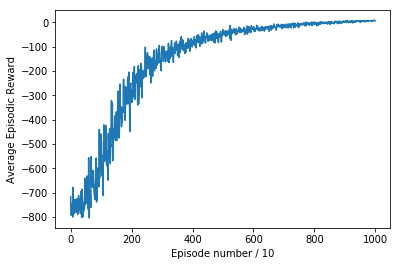

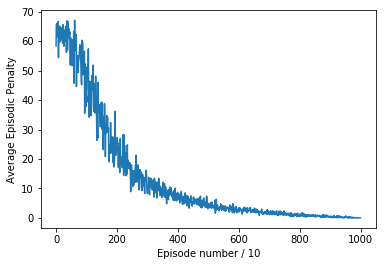

In [4]:
''' Computing averages over given interval as parameter avg_len'''
def getPeriodicAverage(arr, avg_len):
    x = []
    y = []
    for i in range(int(len(arr)/avg_len)):
        x.append(i)
        y.append(np.mean([arr[j] for j in range(avg_len*i, avg_len*i +  avg_len) ]))
    return x,y

'''A utility to plot the episodc reward and penalties'''
def getPlots( rewards, penalties):
    plt.figure()
    x_reward , y_reward = getPeriodicAverage(rewards, 10)
    plt.xlabel("Episode number / 10")
    plt.ylabel("Average Episodic Reward")
    plt.plot(x_reward,y_reward)

    plt.figure()
    x_penalty, y_penalty = getPeriodicAverage(penalties, 10)
    plt.xlabel("Episode number / 10")
    plt.ylabel("Average Episodic Penalty")
    plt.plot( x_penalty, y_penalty)

getPlots(rewards, penalties)

test_rewards, test_penalties = learnedTDAgent.test()
avg_episodic_reward = np.mean(test_rewards)
avg_episodic_penalty = np.mean(test_penalties)
print("Average Episodic Reward Finally ", avg_episodic_reward)
print("Average Episodic Penalty Finally ", avg_episodic_penalty)

In [5]:
# Sample Run
learnedTDAgent.runEpisodeForTest(env_render=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
0 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
1 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
2 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
3 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
4 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
4 3 4 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
3 3 4 1
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
2 3 4 1
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
1 3 4 1
+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------

(9.0, 0)

## Teacher Class

This Teacher class is a wrapper for implementing the teacher functionality. 

Its parameters include a budget. Hence we are looking at action advising under a budget. 
It implements an advise function which depending on the algorithm advises an action based on 
( state, action , budget ) 

If the teacher budget has gone down to 0 then the student action is returned. 

For heuristic based methods there is no need for another class and hence they have been implemented
here itself namely 
 
- Early Advising
- Importance Advising
- Mistake-Correcting
- Decreasing Threshold

On top of it, it also serves as a wrapper for "Q-Teaching"


In [6]:
class Teacher():
    def __init__(self, agent, budget=40000, threshold=0.75, mode='early-advising'):
        self.agent = agent
        self.budget = budget
        self.mode = mode
        self.threshold = threshold
        self.importance = np.zeros(agent.env.observation_space.n)
        self.decrease_rate = 0.2/budget
    
    def advise(self,state, student_action):
        if self.budget == 0:
            return student_action
        if self.mode == 'Q-Teaching':
            recommended_action = self.agent.giveAdvice(state, student_action, self.budget)
            self.budget = self.budget - 1
            return recommended_action
        new_action = self.agent.getAction(state)
        if self.mode == 'early-advising':
            self.budget = self.budget - 1
            return new_action
        if self.mode == 'importance-advising':
            self.importance[state] = 1 -(np.min(self.agent.Q[state,:])/np.max(self.agent.Q[state,:]))
            if self.importance[state] > self.threshold:
                self.budget = self.budget - 1
                return new_action
        if self.mode == 'mistake-correcting' and new_action!= student_action:
            self.importance[state] = 1 -(np.min(self.agent.Q[state,:])/np.max(self.agent.Q[state,:]))
            if self.importance[state] > self.threshold:
                self.budget = self.budget - 1
                return new_action
        if self.mode == 'decrease-threshold' and new_action!= student_action:
            self.importance[state] = 1 -(np.min(self.agent.Q[state,:])/np.max(self.agent.Q[state,:]))
            if self.importance[state] > self.threshold:
                self.budget = self.budget - 1
                self.threshold  = self.threshold - self.decrease_rate
                return new_action

        return student_action

### Importance Advising Training Plots

Budget For Important Advising Teacher Remaining after training:  0


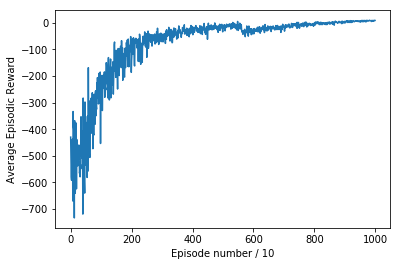

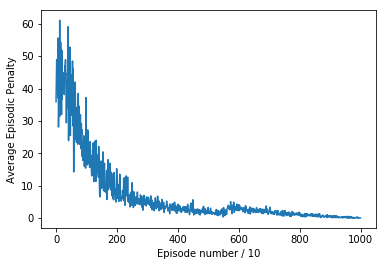

In [7]:
ImpAdvisingTeacher = Teacher(agent= learnedTDAgent, mode='importance-advising')
student_importance = TDAgent(algorithm='Q-Learning', teacher=ImpAdvisingTeacher,)
impAdvisingReward, impAdvisingPenalty = student_importance.train(num_episodes=10000)
print("Budget For Important Advising Teacher Remaining after training: ", ImpAdvisingTeacher.budget)
getPlots(impAdvisingReward, impAdvisingPenalty)


### Early Advising Training Plots

Budget For Early Advising Teacher Remaining after training:  0


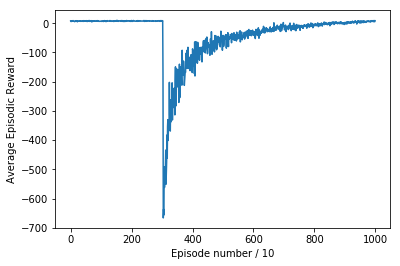

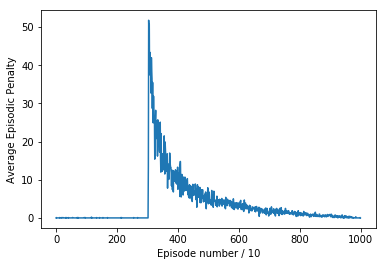

In [8]:
EarlyAdvisingTeacher = Teacher(agent= learnedTDAgent, mode='early-advising')
student_early = TDAgent(algorithm='Q-Learning', teacher=EarlyAdvisingTeacher,)
earlyAdvisingReward, earlyAdvisingPenalty = student_early.train(num_episodes=10000)
print("Budget For Early Advising Teacher Remaining after training: ",EarlyAdvisingTeacher.budget)
getPlots(earlyAdvisingReward, earlyAdvisingPenalty)

### Mistake Correcting Training Plots

Budget For Mistake Correcting Teacher Remaining after training:  10442


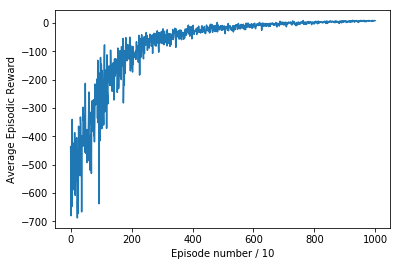

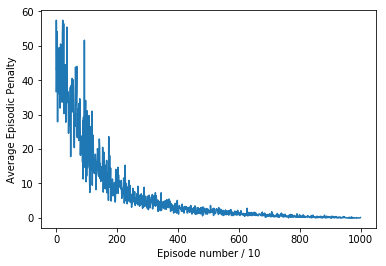

In [9]:
MistakeCorrectingTeacher = Teacher(agent= learnedTDAgent, mode='mistake-correcting')
student_mistake = TDAgent(algorithm='Q-Learning', teacher=MistakeCorrectingTeacher)
mistakeCorrectingReward, mistakeCorrectingPenalty = student_mistake.train(num_episodes=10000)
print("Budget For Mistake Correcting Teacher Remaining after training: ",MistakeCorrectingTeacher.budget)
getPlots(mistakeCorrectingReward, mistakeCorrectingPenalty)


### Decreasing Threshold training plots

Budget For decreasing Threshold Teacher Remaining after training:  8382


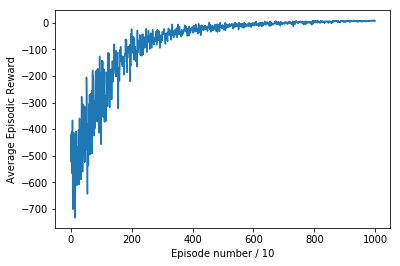

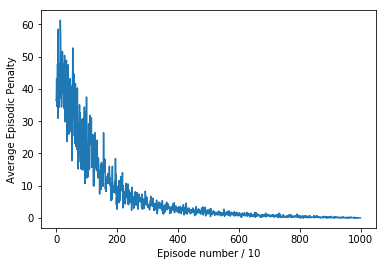

In [10]:
DecreaseThresholdTeacher = Teacher(agent= learnedTDAgent, mode='decrease-threshold')
student_decrease = TDAgent(algorithm='Q-Learning', teacher=DecreaseThresholdTeacher)
decreaseReward, decreasePenalty = student_decrease.train(num_episodes=10000)
print("Budget For decreasing Threshold Teacher Remaining after training: ",DecreaseThresholdTeacher.budget)
getPlots(decreaseReward, decreasePenalty)

### Comparison of training plots

Here we plot all the trainings in a single figure to analyze the differences between the algorithms. 
We have also plotted the original Q-Learning scheme here.

It is important to acknowledge that apart from early-advising all schemes perform better than the original
learning. The early advising graph starts from a high but the agent is unable to learn a lot and hence only gets a little bit of a start. 

The others are able to learn in a better way. 
In Mistake-Correcting if we look its plot above, the budget remains even after training indicating that it is able to provide better performance than Important Advising in terms of efficiently using the budget. 

Also Important Advising has a small drop in performance and then it recovers again but both Decreasing threshold and Mistake Correcting are smoother curves than their other counterparts.

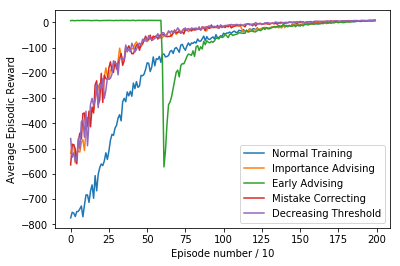

In [11]:
plt.figure()
plt.xlabel("Episode number / 10")
plt.ylabel("Average Episodic Reward")
x_reward , y_reward = getPeriodicAverage(rewards, 50)
plt.plot(x_reward,y_reward, label='Normal Training')
x_reward , y_reward = getPeriodicAverage(impAdvisingReward, 50)
plt.plot(x_reward,y_reward,label='Importance Advising')
x_reward , y_reward = getPeriodicAverage(earlyAdvisingReward, 50)
plt.plot(x_reward,y_reward, label='Early Advising')
x_reward , y_reward = getPeriodicAverage(mistakeCorrectingReward, 50)
plt.plot(x_reward,y_reward, label='Mistake Correcting')
x_reward , y_reward = getPeriodicAverage(decreaseReward, 50)
plt.plot(x_reward,y_reward, label='Decreasing Threshold')
plt.legend()

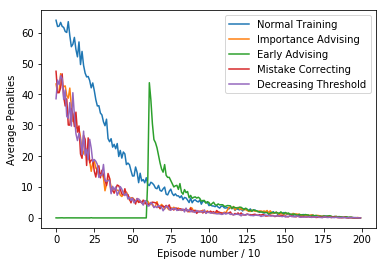

In [12]:
plt.figure()
plt.xlabel("Episode number / 10")
plt.ylabel("Average Penalties")
x_reward , y_reward = getPeriodicAverage(penalties, 50)
plt.plot(x_reward,y_reward, label='Normal Training')
x_reward , y_reward = getPeriodicAverage(impAdvisingPenalty, 50)
plt.plot(x_reward,y_reward,label='Importance Advising')
x_reward , y_reward = getPeriodicAverage(earlyAdvisingPenalty, 50)
plt.plot(x_reward,y_reward, label='Early Advising')
x_reward , y_reward = getPeriodicAverage(mistakeCorrectingPenalty, 50)
plt.plot(x_reward,y_reward, label='Mistake Correcting')
x_reward , y_reward = getPeriodicAverage(decreasePenalty, 50)
plt.plot(x_reward,y_reward, label='Decreasing Threshold')
plt.legend()

### Comparison over other algorithms for training student

It is observed that Q-Learning performs best while SARSA and Expected-Sarsa are a  little less stable and take more time to reach to convergence.

In [13]:
algorithms = [ 'Q-Learning', 'Sarsa', 'Expected-Sarsa']
algoTestRewards = []
algoTestPenalties = []
for algorithm in algorithms:
    ImpAdvisingTeacher = Teacher(agent= learnedTDAgent, mode='importance-advising')
    student_importance = TDAgent(algorithm=algorithm, teacher=ImpAdvisingTeacher)
    impAdvisingReward, impAdvisingPenalty = student_importance.train(num_episodes=10000)
    algoTestRewards.append(impAdvisingReward)
    algoTestPenalties.append(impAdvisingPenalty)

/home/nirvan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

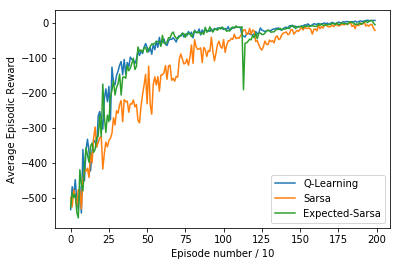

In [14]:
plt.figure()
plt.figure()
plt.xlabel("Episode number / 10")
plt.ylabel("Average Episodic Reward")
for i,algorithm in enumerate(algorithms):
    x_reward , y_reward = getPeriodicAverage(algoTestRewards[i], 50)
    plt.plot(x_reward,y_reward, label=algorithm)
plt.legend()

## Implementation of the Q-Teaching Algorithm

In this case the teacher is itself an RL Agent with its own reward function. The budget space is discretized for computational reasons. 

The teacher state is made up of ( task_state, student_intended_action, budgetLeft )

This entire teacher_state is encoded to a single value for ease of calculations. 

The training procedure of the teacher follows two cyclic sessions:
- A training session in which a teacher episode is started with fixed budget and continued until the budget finishes or a fixed number of steps have been taken. If the task agent reaches end state it is restarted. 

- An evaluation session for 10 episodes after every 30 training epsiodes. In this step the student is tested with its current policy on the given task and its rewards and penalties.

Below is the Q-Teaching algorithm as presented in the paper.


## The Q-Teaching Algorithm 


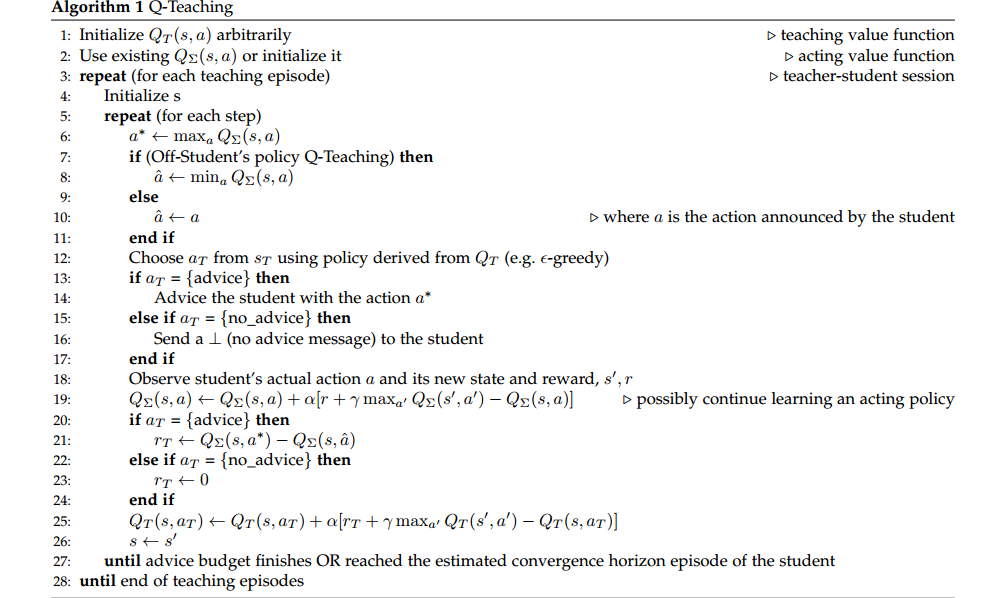

In [20]:
class Q_Teaching:
    def __init__(self,  agent, student, teacher_episodes=100, epsilon=1e-9, budget=100, alpha=0.2, gamma=0.98, 
                episode_stack = 10, maxStepsForEpisode = 1000, off_policy_student=True):
        self.num_teaching_episodes = teacher_episodes
        self.task_policy = agent.policy
        self.q_task = agent.Q
        self.off_policy_student = off_policy_student
        self.state = None
        self.episode_stack = episode_stack
        self.budget = budget 
        self.env = agent.env
        self.alpha = alpha
        self.actions = np.arange(int(self.env.action_space.n) + 1)
        self.taskSpace = self.env.observation_space.n
        self.discreteBudget = int(budget/self.episode_stack)+1
        self.gamma = gamma
        self.teacherStateSize = self.env.observation_space.n * self.env.action_space.n * self.discreteBudget
        self.q = np.zeros((self.teacherStateSize, len(self.actions)))
        self.policy = np.full((self.teacherStateSize, len(self.actions)), 1.0/len(self.actions))
        self.student = student
        self.epsilon = epsilon
        self.budgetForEveryEpisode = budget-1
        self.maxStepsForEpisode = maxStepsForEpisode
        self.evaluateInterval = 30
        self.numTestEpisodes = 10
 
    def encodeTeacherState( self, task_state, student_action, budgetLeft):
        return int(budgetLeft/self.episode_stack) + self.discreteBudget*(student_action +self.env.action_space.n*task_state)
        
    def decodeTeacherState( self, teacher_state):
        cur =  self.env.action_space.n*self.discreteBudget
        task_state = teacher_state/ cur
        teacher_state = teacher_state - cur*task_state
        cur = cur/ self.env.action_space.n
        action = teacher_state/ cur
        teacher_state = teacher_state - cur*action
        budgetLeft = teacher_state
        return (task_state, action, budgetLeft)
                            
    def update_policy(self,state, epsilon=0.1):
        self.policy[state, :] = epsilon/len(self.actions)
        self.policy[state, np.argmax(self.q[state, :])] += (1.0 - epsilon)
        
    def hasEpisodeConverged(self,old_value, new_value):
        if self.budget == 0:
            return True
        if self.steps == self.maxStepsForEpisode:
            return True
        return False
    
    
    def giveAdvice(self, state, student_action, budget):
        budget = min(int(budget/ self.episode_stack),self.discreteBudget-1)
        action = np.argmax(self.policy[self.encodeTeacherState(state, student_action, budget)])
        #print(action)
        if action == len(self.actions)-1:
            return student_action
        else:
            return action
        
    def getTeacherAction(self, state):
        return np.random.choice(self.actions, p=self.policy[state,:])
    
    def getTeacherState(self, state, action):
        return int(self.encodeTeacherState(state, action, self.budget))
    
    def initialize_episode(self):
        self.task_state = student.reset()
        self.budget = self.budgetForEveryEpisode
        self.steps = 0
        
    '''This is the main function which implements the main Q-Teaching algorithm as stated. This runs just 
      a single  teacher episode  of training. In itself it may include multiple episodes of the task. Every time 
      the task state reaches its goal, it is restart to cover all combinations of task states and budget'''
    def runEpisodeForTraining(self, epsilon):
    
        self.initialize_episode()
        student_action = self.student.getAction(self.task_state)
        teacher_state = self.getTeacherState(self.task_state, student_action) # compose the teacher state
        old_value = 0.0
        new_value = 1.0
        total_episodic_reward = 0.0
        total_steps = 0
        while(self.hasEpisodeConverged(old_value, new_value) == False):

            self.steps = self.steps + 1
            # Step 1: Find which are the best and worst actions for the task
            best_action = np.argmax(self.q_task[self.task_state,:]) 
            worst_action = np.argmin(self.q_task[self.task_state,:])
            #print(teacher_state)
            # Step 2: Get the action recommendation using teacher state
            teacher_recommended_action = self.getTeacherAction(teacher_state) 

            # Step 3: Execute the recommended action in student space and observe the next state
            next_task_state, student_action , reward, done = student.recommend(teacher_recommended_action,epsilon)

            # Step 4: Update q-value for the task using Q-Learning update
            if done:
                self.q_task[self.task_state, student_action] = (1.0 - self.alpha)* \
                    self.q_task[self.task_state, student_action] + self.alpha*reward
            else:
                self.q_task[self.task_state, student_action] = (1.0 - self.alpha)* \
                self.q_task[self.task_state, student_action] + self.alpha *( reward + self.gamma*np.max(self.q_task[next_task_state,:]))
            
            # Step 5: Compute the reward for the teacher for such a scenario
            if self.off_policy_student == False:
                worst_action = student_action

            teacher_reward = 0.0
            if teacher_recommended_action < len(self.actions)-1:
                teacher_reward = self.q_task[self.task_state,best_action]- self.q_task[self.task_state, worst_action]
                self.budget = self.budget - 1

            total_episodic_reward = total_episodic_reward + teacher_reward
            total_steps = total_steps + 1
            # Step 6: Update q-values for teaching policy using reward
            self.task_state = next_task_state

            student_action =  student.getAction(next_task_state)
            new_teacher_state = self.getTeacherState(self.task_state, student_action)

            self.q[teacher_state,teacher_recommended_action] = (1.0 - self.alpha) *  \
            self.q[teacher_state,teacher_recommended_action] + self.alpha * \
                (teacher_reward + self.gamma* np.max(self.q[new_teacher_state,:]) )

            self.update_policy(teacher_state, epsilon)
#                 print(old_pair, old_value, new_value)
            self.state = new_teacher_state
            teacher_state = new_teacher_state
        
        return total_episodic_reward, total_steps 

    def testStudentAgent(self, num_episodes):
        test_rewards , test_penalties =  self.student.test(num_episodes)
        return np.mean(test_rewards), np.mean(test_penalties)
    
    ''' This implements the training procedure comprising training and evaluation sessions'''
    def train(self, training_episodes=4000):
        episodic_rewards = []
        step_rewards = []
        evalRewards = []
        evalPenalties = []
        for teaching_episode in range(training_episodes):
            if teaching_episode % self.evaluateInterval == 0: # evaluation session
                mean_test_reward, mean_test_penalty  = self.testStudentAgent(self.numTestEpisodes)
                evalRewards.append(mean_test_reward)
                evalPenalties.append(mean_test_penalty)
            epsilon = 1.0 - (teaching_episode/training_episodes)
            episodic_reward, step_count = self.runEpisodeForTraining(epsilon)
            episodic_rewards.append(episodic_reward)
            step_rewards.append(episodic_reward/step_count)
            
            if teaching_episode % 1000 == 0:
                print(teaching_episode)
        return episodic_rewards, step_rewards, evalRewards, evalPenalties
        
            
 
        

In [21]:
student = TDAgent('Q-Learning')

In [22]:
teacher = Q_Teaching(learnedTDAgent, student)

In [23]:
# Test the basic functions
print("Action Space for teacher: ", teacher.actions)
print("Q Table shape", teacher.q.shape)
print("Discretized Budget ", teacher.discreteBudget)

Action Space for teacher:  [0 1 2 3 4 5 6]
Q Table shape (33000, 7)
Discretized Budget  11


In [24]:
 episodic_rewards, step_rewards, evalRewards, evalPenalties = teacher.train()

0
1000
2000
3000


## Plotting the teacher's episodic reward 

The teacher's episodic reward dependes on the difference of Q-values of best and worst states.
Following is an analysis of the training: 
- Initially the student does not know the right decision to take for important states that is states with very high difference in their Q-values. Hence initially in the beginning rewards are higher and start decreasing as  the student learns about the most important states. 

- With more time the states concentrated on have a relatively smaller difference and the teacher learns in this case to spend budget more cautiously, since previously a single use of budget meant a great increase in reward. But this is not the case here. Hence the shape of the curve becomes like a upward plateau. 

- Slowly after some episodes of training, when the student has been trained the rewards seem to decrease since teacher is now less required for advising. 

Thus there are three stages of student and the training reward of teacher shows the rewards the teacher get for each of these student stages namely 
- Untrained Student
- Semi-trained Student
- Trained Student

We have plotted the average episodic reward as well as the average step reward to make sure that the results are not correlated with the number of steps in the episode.


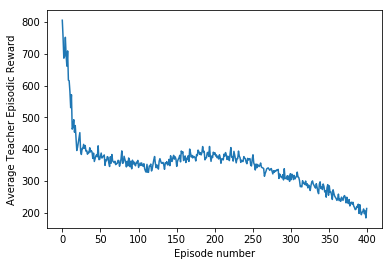

In [25]:
plt.figure()
plt.xlabel("Episode number")
plt.ylabel("Average Teacher Episodic Reward")
x_reward , y_reward = getPeriodicAverage(episodic_rewards,10)
plt.plot(x_reward,y_reward)

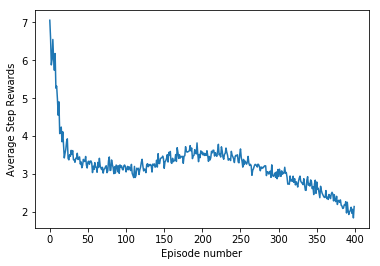

In [26]:
plt.figure()
plt.xlabel("Episode number")
plt.ylabel("Average Step Rewards")
x_reward , y_reward = getPeriodicAverage(step_rewards,10)
plt.plot(x_reward,y_reward)

## Plot for student used for training

Here we have plotted the progress of the student during all the evaluation sessions. It shows how with 
time the student learnt the task policy with the help of advice from teacher. This is not necessary though because our final aim is to train the teacher not the student.

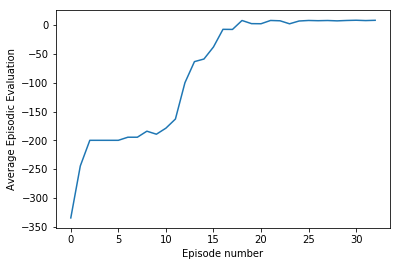

In [27]:
plt.figure()
plt.xlabel("Episode number")
plt.ylabel("Average Episodic Evaluation")
x_reward , y_reward = getPeriodicAverage(evalRewards,4)
plt.plot(x_reward,y_reward)

In [28]:
student.runEpisodeForTest(env_render=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
2 0 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
2 1 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
2 2 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
2 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
3 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
4 3 3 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
4 3 4 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
3 3 4 1
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
2 3 4 1
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+


(8.0, 0)

### Testing the Teacher on a random student

Now we use the teacher trained using Q-Teaching and train an agent with actions advised from the 
Q-Teacher. The number of episodes is halved ( = 5000 ). Note that we have trained our teacher with a very less available budget but still it is able to advise the student and help it train within 5000 episodes which is half of the time taken in earleer methods. 

The plots have been drawn for both on-policy and off-policy teachers. 
Off-Policy teachers have their reward dependent on the difference between Q-values of best and worst actions. 
However in on-policy teachers the reward is dependent on the difference between Q-values of best action and that of the student action in that state.

Budget For Q-Teaching Teacher Remaining after training:  0


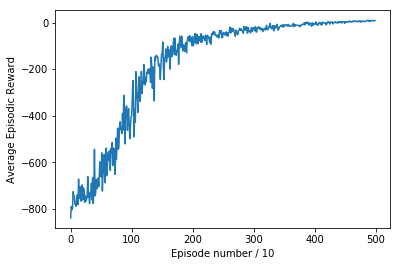

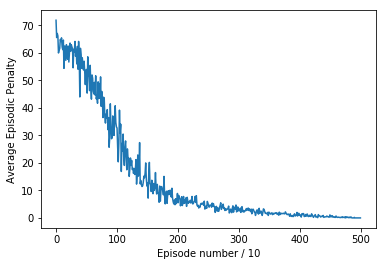

In [29]:
QLearningTeacher= Teacher(agent=teacher,budget=1000, mode='Q-Teaching')
student_qlearning = TDAgent(algorithm='Q-Learning', teacher=QLearningTeacher)
qTeachingReward, qTeachingPenalty = student_qlearning.train(num_episodes=5000)
print("Budget For Q-Teaching Teacher Remaining after training: ", QLearningTeacher.budget)
getPlots(qTeachingReward, qTeachingPenalty)

0
1000
2000
3000
Budget For Q-Teaching Teacher Remaining after training:  0


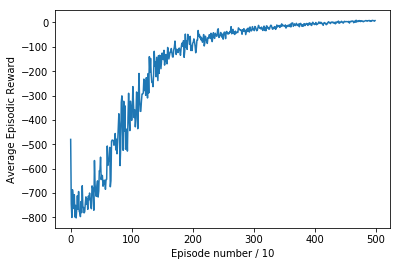

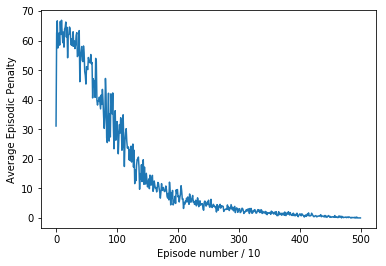

In [30]:
student = TDAgent('Q-Learning')
onPolicyteacher = Q_Teaching(learnedTDAgent, student, off_policy_student=False)
episodic_rewards, step_rewards, evalRewards, evalPenalties = teacher.train()

OnPolicyTeacher= Teacher(agent=onPolicyteacher,budget=1000, mode='Q-Teaching')
student_qlearning = TDAgent(algorithm='Q-Learning', teacher=OnPolicyTeacher)
qTeachingRewardOn, qTeachingPenaltyOn = student_qlearning.train(num_episodes=5000)
print("Budget For Q-Teaching Teacher Remaining after training: ", QLearningTeacher.budget)
getPlots(qTeachingRewardOn, qTeachingPenaltyOn)

## Comparison of Q-Teaching with others

Now here we have plotted the previous best approaches of mistake-correcting and compared it with Off-Policy and On-Policy Q-Teaching. Both are way better than normal Q-Learning. But Q-teaching offers a much more generalized and smmooth advising. 

It reaches a higher convergence reward in half the number of episodes. The performance of the agent is also stable and the curve appears to be similar to the Q-Learning curve only a lot steeper and a higher reward.

This points to the fact the mistake-correcting approaches although can give a higher start for the agent, but it takes time for the agent to adjust to their advice.

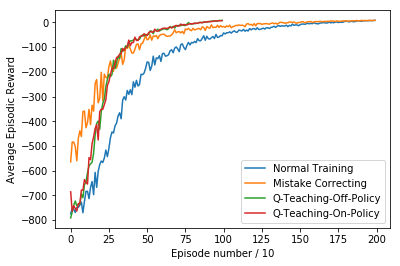

In [31]:
plt.figure()
plt.xlabel("Episode number / 10")
plt.ylabel("Average Episodic Reward")
x_reward , y_reward = getPeriodicAverage(rewards, 50)
plt.plot(x_reward,y_reward, label='Normal Training')
x_reward , y_reward = getPeriodicAverage(mistakeCorrectingReward, 50)
plt.plot(x_reward,y_reward, label='Mistake Correcting')
x_reward , y_reward = getPeriodicAverage(qTeachingReward, 50)
plt.plot(x_reward,y_reward, label='Q-Teaching-Off-Policy')
x_reward , y_reward = getPeriodicAverage(qTeachingRewardOn, 50)
plt.plot(x_reward,y_reward, label='Q-Teaching-On-Policy')
plt.legend()